## Complementary analysis of song lyric length distribution by tokens

In [ ]:
import os
import gc
import pandas as pd
import numpy as np
import shutil
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from tqdm import tqdm
from huggingface_hub import create_repo, upload_folder, login
from utils_dl import set_global_seed


torch.cuda.empty_cache()

We use the Longformer tokenizer

In [ ]:
SEED=42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
HF_TOKEN = "your_token_here" 
BASE_MODEL = "PlanTL-GOB-ES/longformer-base-4096-bne-es"
REPO_ID = f"SeTo97/{BASE_MODEL.split('/')[-1]}_ft_90"

set_global_seed(SEED)

login(token=HF_TOKEN)

## TASK 1

In [ ]:
file_path =  'new_data\subtask1\subtask1_train_rev002.csv'

if os.path.exists(file_path):
    full_data = pd.read_csv(file_path, encoding='utf-8')
    print("File found:")
    print(full_data.info())
else:
    raise FileNotFoundError(f"File not found at {file_path}")



train_dataset = Dataset.from_pandas(full_data.reset_index(drop=True))

ds = DatasetDict({
    'train': train_dataset,

})

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
texts = ds["train"]['lyrics']

# Tokenize without truncation
token_lengths = [
    len(tokenizer(text, truncation=False)["input_ids"])
    for text in tqdm(texts, desc="Tokenizing")
]


File found:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2104 non-null   object
 1   lyrics  2104 non-null   object
 2   label   2104 non-null   object
dtypes: object(3)
memory usage: 49.4+ KB
None


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Tokenizing: 100%|██████████| 2104/2104 [00:03<00:00, 676.68it/s]


In [ ]:
labels = ds["train"]['label']
labels = ["Misogynistic" if label == "M" else "Non-Misogynistic" for label in labels]

In [ ]:
print(f"Mean length: {np.mean(token_lengths):.2f}")
print(f"Median length: {np.median(token_lengths)}")
print(f"90th percentile: {np.percentile(token_lengths, 90)}")
print(f"Max length: {np.max(token_lengths)}")
print("Total Samples in dataset", len(train_dataset))

Mean length: 509.33
Median length: 391.5
90th percentile: 970.0
Max length: 4513
Total Samples in dataset 2104


In [ ]:
labels_to_analyze = ['NM', 'M']

for label in labels_to_analyze:
    print(f"\n--- Stats for label: {label} ---")

    # Filter dataset by label
    subset = ds['train'].filter(lambda example: example['label'] == label)

    texts = subset['lyrics']

    # Tokenize without truncation and compute input lengths
    token_lengths_type_1 = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(texts, desc=f"Tokenizing ({label})")
    ]

    print(f"\nMean length: {np.mean(token_lengths_type_1):.2f}")
    print(f"Median length: {np.median(token_lengths_type_1)}")
    print(f"90th percentile: {np.percentile(token_lengths_type_1, 90)}")
    print(f"Max length: {np.max(token_lengths_type_1)}")
    print(f"Min length: {np.min(token_lengths_type_1)}")
    print(f"Total samples: {len(token_lengths_type_1)}")




--- Stats for label: NM ---


Filter:   0%|          | 0/2104 [00:00<?, ? examples/s]

Tokenizing (NM): 100%|██████████| 1462/1462 [00:01<00:00, 753.40it/s]


Mean length: 405.22
Median length: 336.5
90th percentile: 696.1000000000008
Max length: 2571
Min length: 23
Total samples: 1462

--- Stats for label: M ---


Filter:   0%|          | 0/2104 [00:00<?, ? examples/s]

Tokenizing (M): 100%|██████████| 642/642 [00:01<00:00, 560.26it/s]


Mean length: 746.40
Median length: 682.5
90th percentile: 1261.5
Max length: 4513
Min length: 42
Total samples: 642


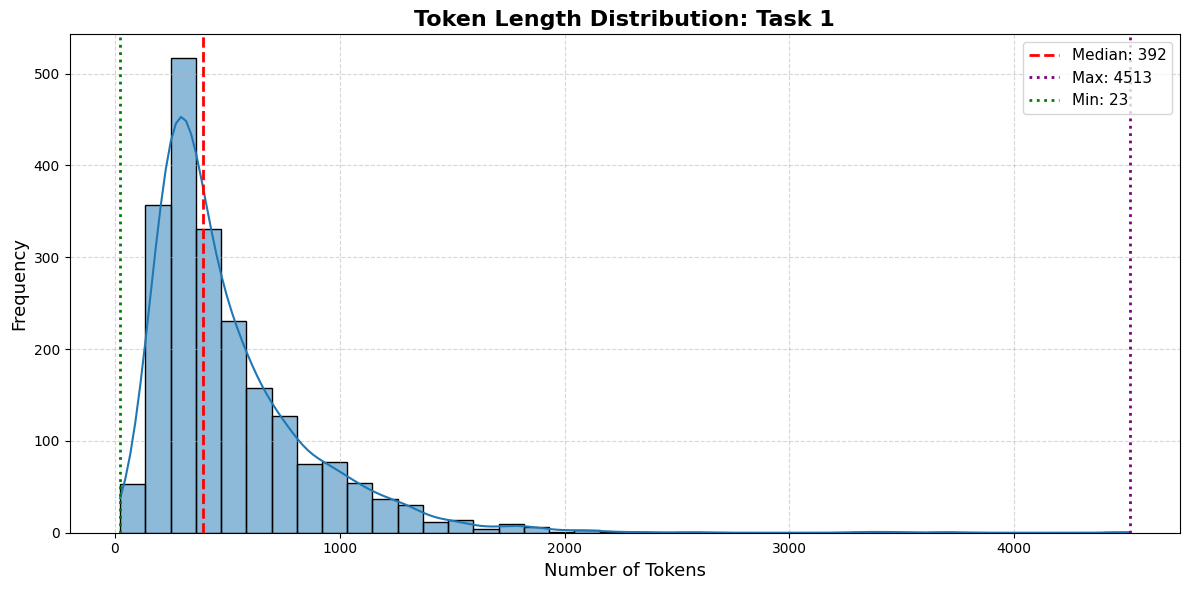

In [ ]:
# mean_val_token = np.mean(token_lengths)
median_val_token = np.median(token_lengths)
# percentile_90 = np.percentile(token_lengths, 90)
max_len = np.max(token_lengths)
min_len = np.min(token_lengths)

plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, bins=40, kde=True, edgecolor='black')

plt.axvline(median_val_token, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val_token:.0f}')
# plt.axvline(percentile_90, color='orange', linestyle='--', linewidth=2, label=f'90th %: {percentile_90:.0f}')
plt.axvline(max_len, color='purple', linestyle=':', linewidth=2, label=f'Max: {max_len:.0f}')
plt.axvline(min_len, color='green', linestyle=':', linewidth=2, label=f'Min: {min_len:.0f}')
# plt.axvline(1024, color='green',linestyle='--', linewidth=2, label='1024')

plt.title('Token Length Distribution: Task 1', fontsize=16, weight='bold')
plt.xlabel('Number of Tokens', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

<ipython-input-25-886066177>:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(


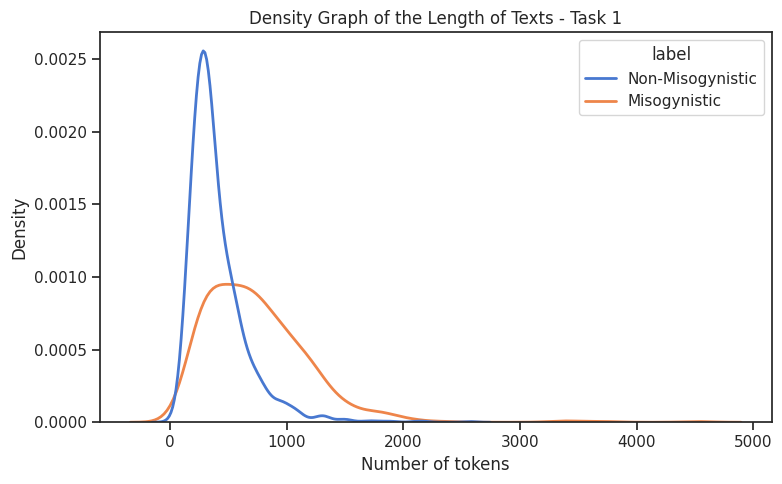

<Figure size 640x480 with 0 Axes>

In [ ]:
df_density = pd.DataFrame({
    'token_length': token_lengths,
    'label': labels
})

colors = sns.color_palette('muted')

sns.set(style="ticks")

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_density,
    x='token_length',
    hue='label',
    palette=colors,      
    common_norm=False,
    linewidth=2
)

plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.title("Density Graph of the Length of Texts - Task 1")
plt.grid(False)  # remove grid
plt.tight_layout()

plt.show()

plt.savefig("token_length_density_task1.png", dpi=300, bbox_inches="tight")

## TASK 2

In [ ]:
file_path =  'new_data\subtask2\subtask1_train_rev002.csv'

if os.path.exists(file_path):
    full_data = pd.read_csv(file_path, encoding='utf-8')
    print("File found:")
    print(full_data.info())
else:
    raise FileNotFoundError(f"File not found at {file_path}")


train_dataset = Dataset.from_pandas(full_data.reset_index(drop=True))

ds = DatasetDict({
    'train': train_dataset,

})

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
texts = ds["train"]['lyrics']

# Tokenize without truncation
token_lengths = [
    len(tokenizer(text, truncation=False)["input_ids"])
    for text in tqdm(texts, desc="Tokenizing")
]


File found:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1168 non-null   object
 1   lyrics  1168 non-null   object
 2   label   1168 non-null   object
dtypes: object(3)
memory usage: 27.5+ KB
None


Tokenizing: 100%|██████████| 1168/1168 [00:01<00:00, 651.63it/s]


In [ ]:
labels_to_analyze = ['S', 'H', 'V', 'NR']

for label in labels_to_analyze:
    print(f"\n--- Stats for label: {label} ---")

    subset = ds['train'].filter(lambda example: example['label'] == label)

    texts = subset['lyrics']

    token_lengths_type_2 = [
        len(tokenizer(text, truncation=False)["input_ids"])
        for text in tqdm(texts, desc=f"Tokenizing ({label})")
    ]

    print(f"Mean length: {np.mean(token_lengths_type_2):.2f}")
    print(f"Median length: {np.median(token_lengths_type_2)}")
    print(f"90th percentile: {np.percentile(token_lengths_type_2, 90)}")
    print(f"Max length: {np.max(token_lengths_type_2)}")
    print(f"Min length: {np.min(token_lengths_type_2)}")
    print(f"Total samples: {len(token_lengths_type_2)}")


--- Stats for label: S ---


Filter:   0%|          | 0/1168 [00:00<?, ? examples/s]

Tokenizing (S): 100%|██████████| 435/435 [00:00<00:00, 510.74it/s]

Mean length: 805.35
Median length: 751.0
90th percentile: 1307.2
Max length: 4513
Min length: 96
Total samples: 435

--- Stats for label: H ---


Filter:   0%|          | 0/1168 [00:00<?, ? examples/s]

Tokenizing (H): 100%|██████████| 78/78 [00:00<00:00, 648.41it/s]

Mean length: 582.10
Median length: 451.5
90th percentile: 1092.7999999999997
Max length: 3448
Min length: 125
Total samples: 78

--- Stats for label: V ---


Filter:   0%|          | 0/1168 [00:00<?, ? examples/s]

Tokenizing (V): 100%|██████████| 129/129 [00:00<00:00, 598.35it/s]

Mean length: 646.98
Median length: 558.0
90th percentile: 1141.0
Max length: 3708
Min length: 42
Total samples: 129

--- Stats for label: NR ---


Filter:   0%|          | 0/1168 [00:00<?, ? examples/s]

Tokenizing (NR): 100%|██████████| 526/526 [00:00<00:00, 846.17it/s]

Mean length: 419.48
Median length: 346.0
90th percentile: 692.5
Max length: 2571
Min length: 40
Total samples: 526


In [ ]:
labels = ds["train"]['label']
labels

label_map_task2 = {
    "S": "Sexualisation",
    "H": "Hate",
    "V": "Violence",
    "NR": "Not Related"
}

labels = [label_map_task2.get(label, label) for label in labels]

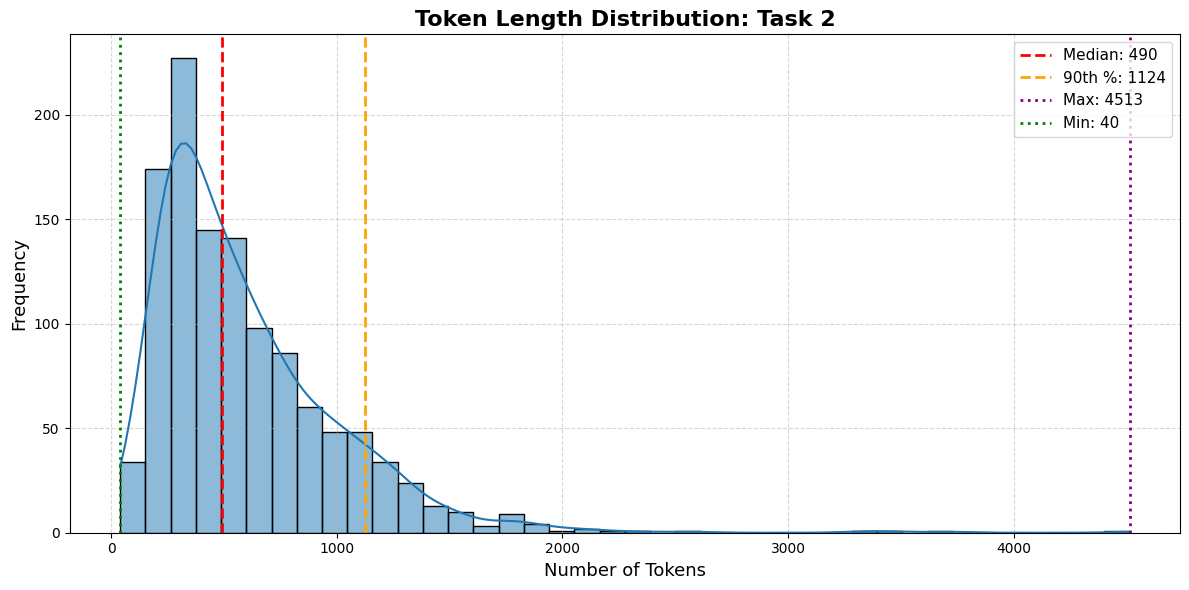

In [ ]:
# mean_val_token = np.mean(token_lengths)
median_val_token = np.median(token_lengths)
percentile_90 = np.percentile(token_lengths, 90)
max_len = np.max(token_lengths)
min_len = np.min(token_lengths)

plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, bins=40, kde=True, edgecolor='black')

plt.axvline(median_val_token, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val_token:.0f}')
plt.axvline(percentile_90, color='orange', linestyle='--', linewidth=2, label=f'90th %: {percentile_90:.0f}')
plt.axvline(max_len, color='purple', linestyle=':', linewidth=2, label=f'Max: {max_len:.0f}')
plt.axvline(min_len, color='green', linestyle=':', linewidth=2, label=f'Min: {min_len:.0f}')
# plt.axvline(1024, color='green',linestyle='--', linewidth=2, label='1024')

plt.title('Token Length Distribution: Task 2', fontsize=16, weight='bold')
plt.xlabel('Number of Tokens', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

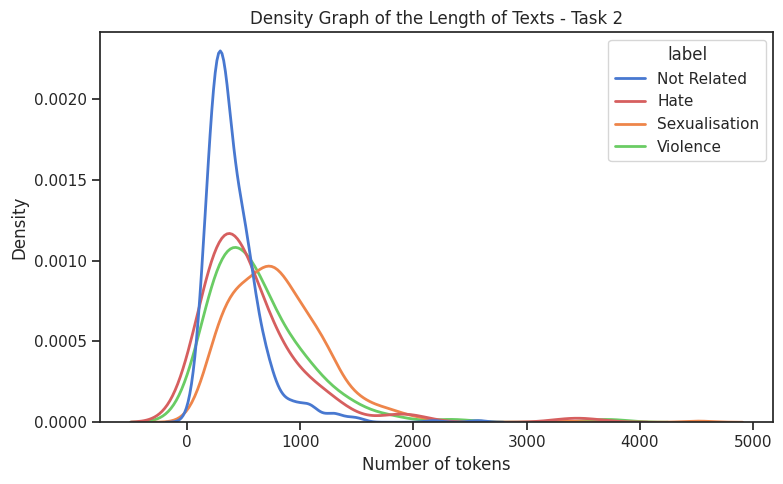

In [ ]:
df_density = pd.DataFrame({
    'token_length': token_lengths,
    'label': labels
})

label_palette = {
    "Sexualisation": "#ee854a",    
    "Violence": "#6acc64",         
    "Hate": "#d65f5f",             
    "Not Related": "#4878d0"       
}

sns.set(style="ticks")

plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_density,
    x='token_length',
    hue='label',
    palette=label_palette,  
    common_norm=False,
    linewidth=2
)

plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.title("Density Graph of the Length of Texts - Task 2")
plt.grid(False)
plt.tight_layout()

plt.show()
